# Leitura Inicial

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tabulate import tabulate
from typing import Dict, List, Optional, Any
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import shutil
import seaborn as sns

In [2]:

def summarize_dataframe(df: pd.DataFrame, df_name: str = "DataFrame"):
  summary = {
      "Nome do DataFrame": df_name,
      "Número de Linhas": df.shape[0],
      "Número de Colunas": df.shape[1],
      "Nomes das Colunas": df.columns.tolist(),
  }

  print(tabulate(summary.items(), headers=['Descrição', 'Informação'], tablefmt='fancy_grid'))
  metrics = df.describe(include='all').transpose()
  print(tabulate(metrics, headers='keys', tablefmt='fancy_grid'))
  valores_ausentes = df.isnull().sum().to_dict()
  valores_ausentes = pd.DataFrame(list(valores_ausentes.items()), columns=['Coluna', 'Valores Ausentes'])
  print(tabulate(valores_ausentes, headers='keys', tablefmt='fancy_grid') + "\n\n")

def plot_dataframe_comparison(dfs_dict: Dict[str, pd.DataFrame], columns: List[str], config: Optional[Dict[str, Any]]):
  n_elements = config.get('n_elements', None)
  choose_randomly = config.get('choose_randomly', False)
  alpha = config.get('alpha', 50)
  chart_types = config.get('chart_types', ['scatter'])
  chart_types_alpha = config.get('chart_types_alpha', 0.6)
  save_plot = config.get('save_plot', False)
  compress = config.get('compress', False)
  if save_plot or compress:
    output_dir = config.get('output_dir', 'plots')
    os.makedirs(output_dir, exist_ok=True)

  data_to_plot = []
  df_column = []
  for column in columns:
    for df_name, df in dfs_dict.items():
        if column in df.columns and not column in df_column:
            if n_elements is None:
              n_elements = int(df[column].shape[0] * max(min(alpha / 100, 1), 0.1))
            data =  df[column]
            data_to_plot.append(data)
            df_column.append(column)

  aligned_data = pd.concat(data_to_plot, axis=1).dropna()

  if not aligned_data.empty:
    if choose_randomly:
        aligned_data = aligned_data.sample(frac=1, random_state=42).reset_index(drop=True)

    if n_elements and len(aligned_data) > n_elements:
        aligned_data = aligned_data.head(min(len(aligned_data), n_elements))

    num_columns = aligned_data.shape[1]

    for i in range(num_columns):
        for j in range(i + 1, num_columns):
            for chart_type in chart_types:
                plt.figure(figsize=(8, 6))

                if chart_type == 'scatter':
                    plt.scatter(aligned_data.iloc[:, i], aligned_data.iloc[:, j], alpha=chart_types_alpha)
                elif chart_type == 'line':
                    plt.plot(aligned_data.iloc[:, i], aligned_data.iloc[:, j], alpha=chart_types_alpha)
                elif chart_type == 'bar':
                    means = [aligned_data.iloc[:, i].mean(), aligned_data.iloc[:, j].mean()]
                    plt.bar([df_column[i], df_column[j]], means)
                elif chart_type == 'box':
                    plt.boxplot([aligned_data.iloc[:, i], aligned_data.iloc[:, j]], labels=[df_column[i], df_column[j]])

                plt.xlabel(df_column[i])
                plt.title(f'{chart_type.capitalize()} Plot: {df_column[i]} vs {df_column[j]}')
                plt.grid(True)
                plt.axhline(0, color='grey', lw=0.8, ls='--')
                plt.axvline(0, color='grey', lw=0.8, ls='--')

                if save_plot or compress:
                    file_name = f"{df_column[i]}_vs_{df_column[j]}_{chart_type}.png"
                    file_path = os.path.join(output_dir, file_name)
                    plt.savefig(file_path, bbox_inches='tight', dpi=300)
                else:
                    plt.show()

                plt.close()

    if save_plot:
      print(f"Plot saved in the directory {output_dir}")
    if compress:
      shutil.make_archive(output_dir, 'zip', output_dir)
      print(f"Final folder with compressed plots")
  else:
      print(f"No column '{column}' found in the DataFrames.")

def plot_nan_heatmap(df):
    columns = df.columns
    pairs = combinations(columns, 2)

    nan_counts = []

    for col1, col2 in pairs:
        count_nan = df[(df[col1].isnull()) & (df[col2].isnull())].shape[0]
        nan_counts.append({'col1': col1, 'col2': col2, 'nan_count': count_nan})

    nan_count_df = pd.DataFrame(nan_counts)

    print(nan_count_df.sort_values(by='nan_count', ascending=False).head(10))

    heatmap_data = nan_count_df.pivot(index='col1', columns='col2', values='nan_count').fillna(0)

    plt.figure(figsize=(12, 10))
    sns.heatmap(heatmap_data, annot=False, cmap='coolwarm', fmt='.0f')
    plt.title('Contagem de Linhas com Valores Faltantes em Pares de Colunas')
    plt.xlabel('Colunas')
    plt.ylabel('Colunas')
    plt.show()

In [3]:
def load_csvs(directory_path: Path, mapping_keys: Optional[Dict[str,str]] = {}) -> Dict[str, pd.DataFrame]:
  dataframes = {}

  for file_path in directory_path.glob('*.csv'):
    filename = file_path.name
    df = pd.read_csv(file_path)
    file_key = filename.rsplit(".", 1)[0]
    file_key = mapping_keys.get(file_key, file_key)
    dataframes[file_key] = df

  return dataframes

In [4]:
# Data menager
folder_data = "."

# Infos
summary_all_df = False
summary_df_names = ["solar_wind", "labels", "satellite_pos", "sunspots"]
df_comparison = False
df_comparison_columns = ['bx_gse', 'by_gse', 'bz_gse', 'theta_gse', 'phi_gse', 'bx_gsm', 'by_gsm', 'bz_gsm', 'theta_gsm', 'phi_gsm', 'bt', 'density', 'speed', 'dst']
df_comparison_config = {"chart_types":["scatter"], "compress": True}

In [5]:
dfs_reader = load_csvs(Path(folder_data))

In [6]:
dfs = dfs_reader.copy()

# Organização inical

In [7]:
sw_data = dfs["solar_wind"].copy()
ssn_data = dfs["sunspots"].copy()
labels_data = dfs["labels"].copy()

# Leitura
sw_data["timedelta"] = pd.to_timedelta(sw_data["timedelta"])
sw_data.drop(columns=["source"], inplace=True)
sw_data.set_index(["period", "timedelta"], inplace=True)

ssn_data["timedelta"] = pd.to_timedelta(ssn_data["timedelta"])
ssn_data.set_index(["period", "timedelta"], inplace=True)

labels_data["timedelta"]  = pd.to_timedelta(labels_data["timedelta"])
labels_data.set_index(["period", "timedelta"], inplace=True)

sw_data_c = sw_data.copy()
ssn_data_c = ssn_data.copy()
labels_data_c = labels_data.copy()

## Backup Ram

In [8]:
sw_data = sw_data_c.copy()
ssn_data = ssn_data_c.copy()
labels_data = labels_data_c.copy()

# Preprocessamento

## Juntar dados

In [9]:
final_data_c = sw_data.copy()

In [10]:
final_data = final_data_c.copy()

## Ajuste de dados

In [11]:
from numpy.random import seed
from tensorflow.random import set_seed

seed(2020)
set_seed(2021)

2024-10-15 20:10:34.208764: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-15 20:10:34.337677: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 20:10:34.383569: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 20:10:34.396818: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-15 20:10:34.478502: I tensorflow/core/platform/cpu_feature_guar

In [12]:
SOLAR_WIND_FEATURES = final_data.columns

In [13]:
final_data = final_data[SOLAR_WIND_FEATURES]

In [14]:
#final_data = final_data.groupby(["period", final_data.index.get_level_values(1).floor('h')]).agg(["mean", "std"])
#final_data.columns = ["_".join(x) for x in final_data.columns]

In [15]:
final_data

bx_gse  by_gse  bz_gse  theta_gse  phi_gse  \
period  timedelta                                                        
train_a 0 days 00:00:00      -5.55    3.00    1.25      11.09   153.37   
        0 days 00:01:00      -5.58    3.16    1.17      10.10   151.91   
        0 days 00:02:00      -5.15    3.66    0.85       7.87   146.04   
        0 days 00:03:00      -5.20    3.68    0.68       6.17   146.17   
        0 days 00:04:00      -5.12    3.68    0.49       4.62   145.72   
...                            ...     ...     ...        ...      ...   
train_c 2435 days 23:55:00   -1.18    2.00   -3.92     -59.28   120.51   
        2435 days 23:56:00   -1.34    2.12   -3.83     -56.78   122.23   
        2435 days 23:57:00   -1.62    2.33   -3.63     -51.98   124.76   
        2435 days 23:58:00   -2.27    2.48   -3.22     -43.81   132.50   
        2435 days 23:59:00   -2.15    2.41   -3.30     -45.55   131.76   

                            bx_gsm  by_gsm  bz_gsm  theta_gsm  phi_gsm    bt  \
period  timedelta                                                              
train_a 0 days 00:00:00      -5.55    3.00    1.25      11.09   153.37  6.80   
        0 days 00:01:00      -5.58    3.16    1.17      10.10   151.91  6.83   
        0 days 00:02:00      -5.15    3.66    0.85       7.87   146.04  6.77   
        0 days 00:03:00      -5.20    3.68    0.68       6.17   146.17  6.74   
        0 days 00:04:00      -5.12    3.68    0.49       4.62   145.72  6.65   
...                            ...     ...     ...        ...      ...   ...   
train_c 2435 days 23:55:00   -1.17    2.98   -3.23     -45.24   111.48  4.56   
        2435 days 23:56:00   -1.33    3.08   -3.12     -42.95   113.45  4.58   
        2435 days 23:57:00   -1.61    3.22   -2.87     -38.57   116.58  4.61   
        2435 days 23:58:00   -2.26    3.25   -2.44     -31.61   124.81  4.65   
        2435 days 23:59:00   -2.15    3.21   -2.53     -33.21   123.75  4.62   

                            density   speed  temperature  
period  timedelta                                         
train_a 0 days 00:00:00        1.53  383.92     110237.0  
        0 days 00:01:00        1.69  381.79     123825.0  
        0 days 00:02:00        1.97  389.11      82548.0  
        0 days 00:03:00        1.97  389.11      82548.0  
        0 days 00:04:00        1.77  384.26      94269.0  
...                             ...     ...          ...  
train_c 2435 days 23:55:00     4.64  348.73      23368.0  
        2435 days 23:56:00     4.27  346.36      26497.0  
        2435 days 23:57:00     3.95  344.12      27050.0  
        2435 days 23:58:00     2.81  338.52      33257.0  
        2435 days 23:59:00     2.30  342.31      32267.0  

[8392320 rows x 14 columns]

In [16]:
final_data = final_data.join(ssn_data)

In [17]:
final_data.smoothed_ssn = final_data.smoothed_ssn.ffill()

In [18]:
final_data

bx_gse  by_gse  bz_gse  theta_gse  phi_gse  \
period  timedelta                                                        
train_a 0 days 00:00:00      -5.55    3.00    1.25      11.09   153.37   
        0 days 00:01:00      -5.58    3.16    1.17      10.10   151.91   
        0 days 00:02:00      -5.15    3.66    0.85       7.87   146.04   
        0 days 00:03:00      -5.20    3.68    0.68       6.17   146.17   
        0 days 00:04:00      -5.12    3.68    0.49       4.62   145.72   
...                            ...     ...     ...        ...      ...   
train_c 2435 days 23:55:00   -1.18    2.00   -3.92     -59.28   120.51   
        2435 days 23:56:00   -1.34    2.12   -3.83     -56.78   122.23   
        2435 days 23:57:00   -1.62    2.33   -3.63     -51.98   124.76   
        2435 days 23:58:00   -2.27    2.48   -3.22     -43.81   132.50   
        2435 days 23:59:00   -2.15    2.41   -3.30     -45.55   131.76   

                            bx_gsm  by_gsm  bz_gsm  theta_gsm  phi_gsm    bt  \
period  timedelta                                                              
train_a 0 days 00:00:00      -5.55    3.00    1.25      11.09   153.37  6.80   
        0 days 00:01:00      -5.58    3.16    1.17      10.10   151.91  6.83   
        0 days 00:02:00      -5.15    3.66    0.85       7.87   146.04  6.77   
        0 days 00:03:00      -5.20    3.68    0.68       6.17   146.17  6.74   
        0 days 00:04:00      -5.12    3.68    0.49       4.62   145.72  6.65   
...                            ...     ...     ...        ...      ...   ...   
train_c 2435 days 23:55:00   -1.17    2.98   -3.23     -45.24   111.48  4.56   
        2435 days 23:56:00   -1.33    3.08   -3.12     -42.95   113.45  4.58   
        2435 days 23:57:00   -1.61    3.22   -2.87     -38.57   116.58  4.61   
        2435 days 23:58:00   -2.26    3.25   -2.44     -31.61   124.81  4.65   
        2435 days 23:59:00   -2.15    3.21   -2.53     -33.21   123.75  4.62   

                            density   speed  temperature  smoothed_ssn  
period  timedelta                                                       
train_a 0 days 00:00:00        1.53  383.92     110237.0          65.4  
        0 days 00:01:00        1.69  381.79     123825.0          65.4  
        0 days 00:02:00        1.97  389.11      82548.0          65.4  
        0 days 00:03:00        1.97  389.11      82548.0          65.4  
        0 days 00:04:00        1.77  384.26      94269.0          65.4  
...                             ...     ...          ...           ...  
train_c 2435 days 23:55:00     4.64  348.73      23368.0          42.5  
        2435 days 23:56:00     4.27  346.36      26497.0          42.5  
        2435 days 23:57:00     3.95  344.12      27050.0          42.5  
        2435 days 23:58:00     2.81  338.52      33257.0          42.5  
        2435 days 23:59:00     2.30  342.31      32267.0          42.5  

[8392320 rows x 15 columns]

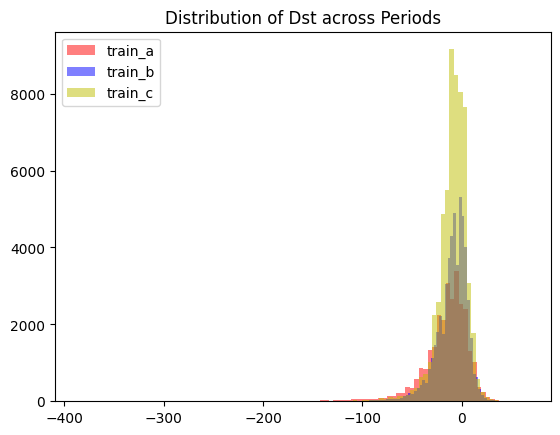

In [19]:
fig, ax = plt.subplots()
colors = ["r", "b", "y"]
for i, period in enumerate(labels_data.groupby("period")):
    period_name, df = period
    ax.hist(df, alpha=0.5, color=colors[i], bins=100, label=period_name)
plt.legend()
plt.title("Distribution of Dst across Periods")
plt.show()

# Normalizar e tratar nan

In [20]:
summarize_dataframe(final_data, "Final Dataframe")

╒═══════════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ Descrição         │ Informação                                                                                                                                                            │
╞═══════════════════╪═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ Nome do DataFrame │ Final Dataframe                                                                                                                                                       │
├───────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ Número de Linhas  │ 8392320                     

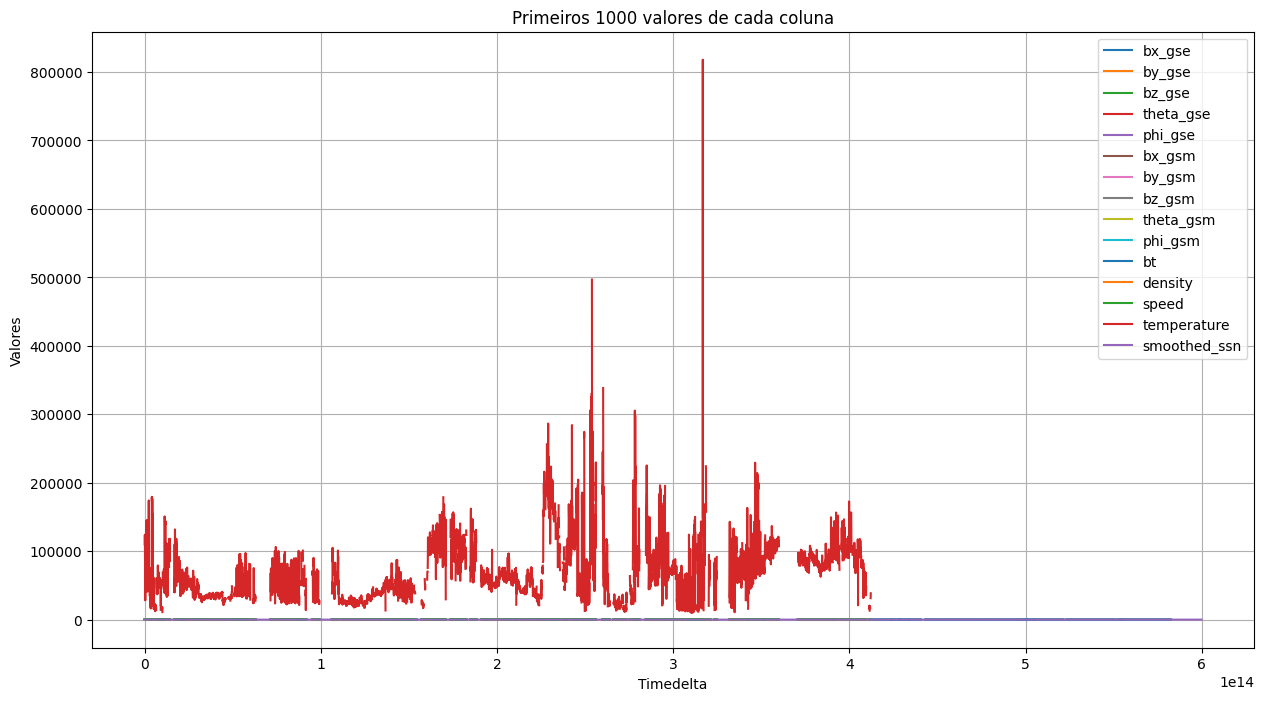

In [21]:
plot_data = final_data[final_data.index.get_level_values(0) == "train_a"].head(10000)

x_values = plot_data.index.get_level_values(1)

plt.figure(figsize=(15, 8))

for col in plot_data.columns:
    plt.plot(x_values, plot_data[col], label=col)

plt.title('Primeiros 1000 valores de cada coluna')
plt.xlabel('Timedelta')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)

plt.show()

In [22]:
final_data = final_data.apply(lambda col: col.interpolate().ffill().bfill(), axis=0)

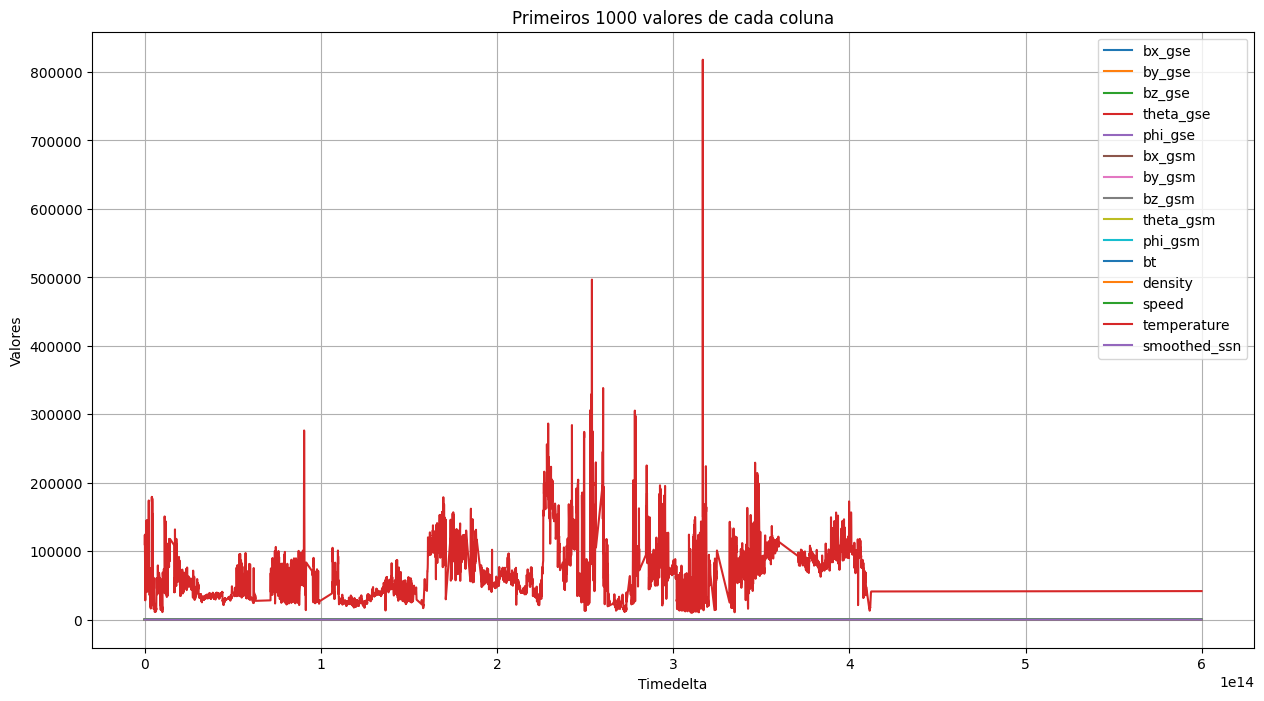

In [23]:
plot_data = final_data[final_data.index.get_level_values(0) == "train_a"].head(10000)

x_values = plot_data.index.get_level_values(1)

plt.figure(figsize=(15, 8))

for col in plot_data.columns:
    plt.plot(x_values, plot_data[col], label=col)

plt.title('Primeiros 1000 valores de cada coluna')
plt.xlabel('Timedelta')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)

plt.show()

In [24]:
def remove_outliers_iqr(df, tx = 1.2):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - tx * IQR
    upper_bound = Q3 + tx * IQR

    return df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]

final_data = remove_outliers_iqr(final_data)

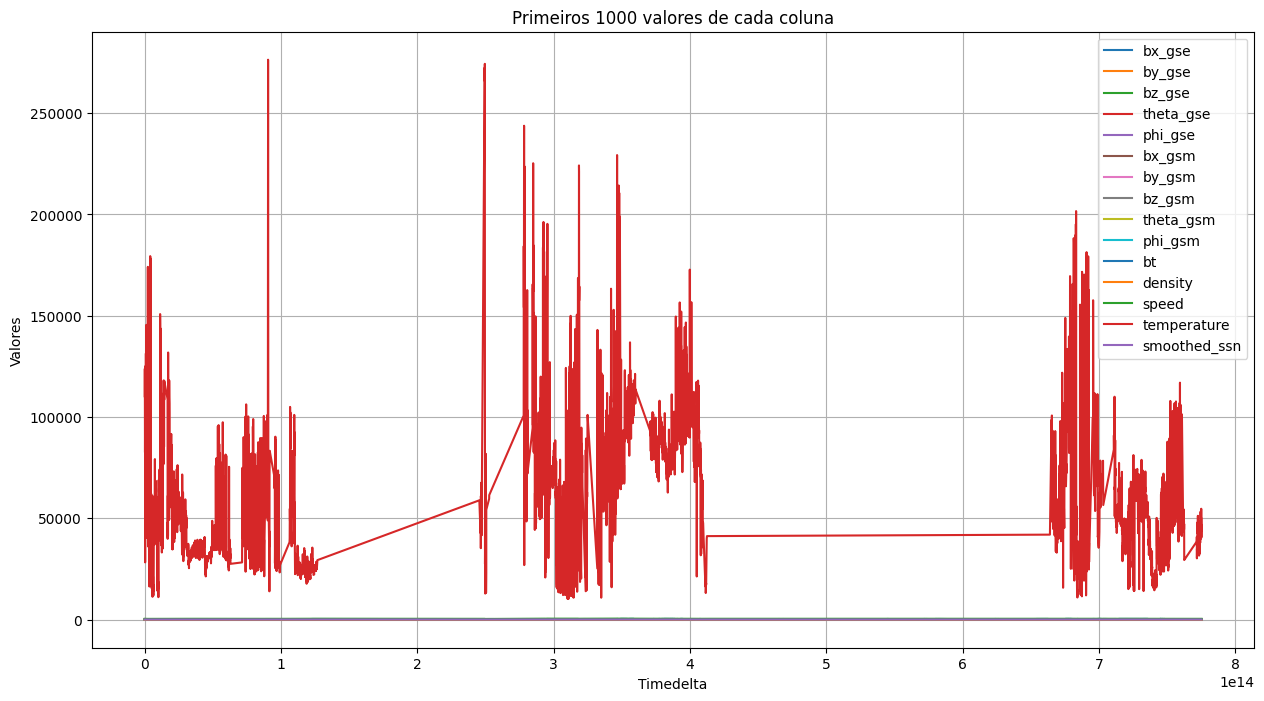

In [25]:
plot_data = final_data[final_data.index.get_level_values(0) == "train_a"].head(10000)

x_values = plot_data.index.get_level_values(1)

plt.figure(figsize=(15, 8))

for col in plot_data.columns:
    plt.plot(x_values, plot_data[col], label=col)

plt.title('Primeiros 1000 valores de cada coluna')
plt.xlabel('Timedelta')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)

plt.show()

In [26]:
scaler = StandardScaler()

df_normalized = pd.DataFrame(scaler.fit_transform(final_data), columns=final_data.columns, index=final_data.index)

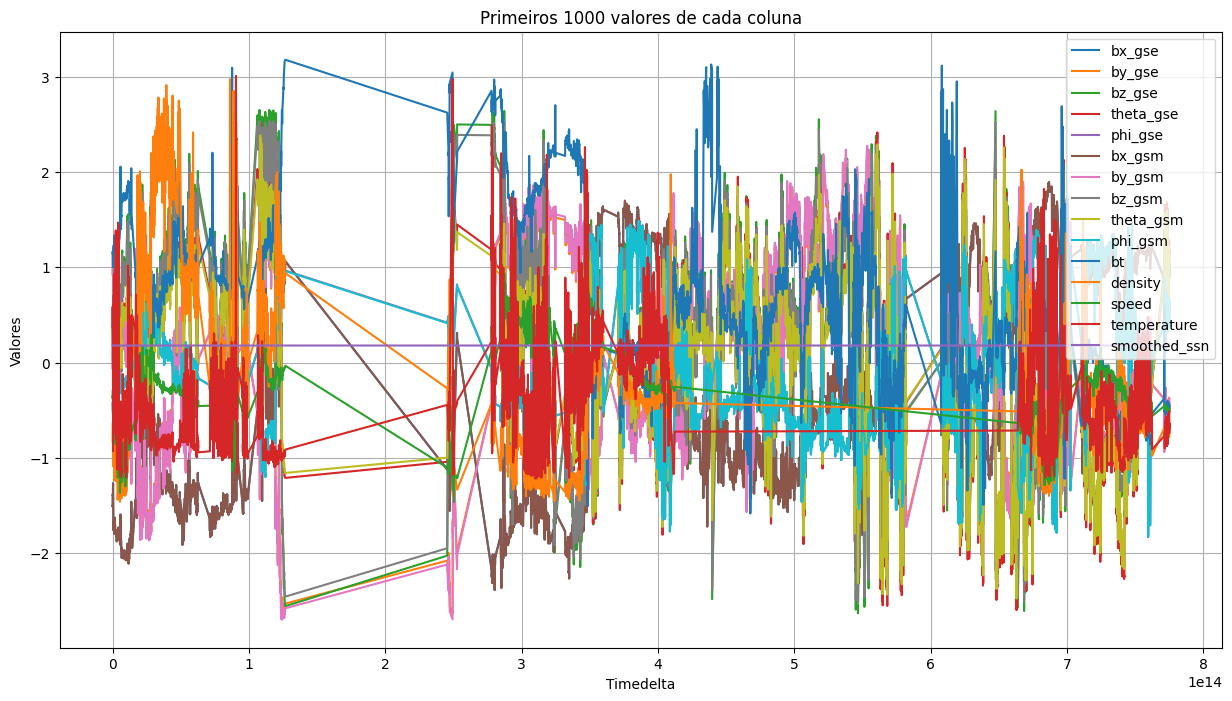

In [27]:
plot_data = df_normalized[df_normalized.index.get_level_values(0) == "train_a"].head(10000)

x_values = plot_data.index.get_level_values(1)

plt.figure(figsize=(15, 8))

for col in plot_data.columns:
    plt.plot(x_values, plot_data[col], label=col)

plt.title('Primeiros 1000 valores de cada coluna')
plt.xlabel('Timedelta')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)

plt.show()

In [28]:
summarize_dataframe(df_normalized, "Final Dataframe")

╒═══════════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ Descrição         │ Informação                                                                                                                                                            │
╞═══════════════════╪═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ Nome do DataFrame │ Final Dataframe                                                                                                                                                       │
├───────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ Número de Linhas  │ 6307345                     

In [29]:
df_normalized['t0'] = labels_data['dst'].shift(0)
df_normalized['t1'] = labels_data['dst'].shift(-1)
df_normalized['t2'] = labels_data['dst'].shift(-2)

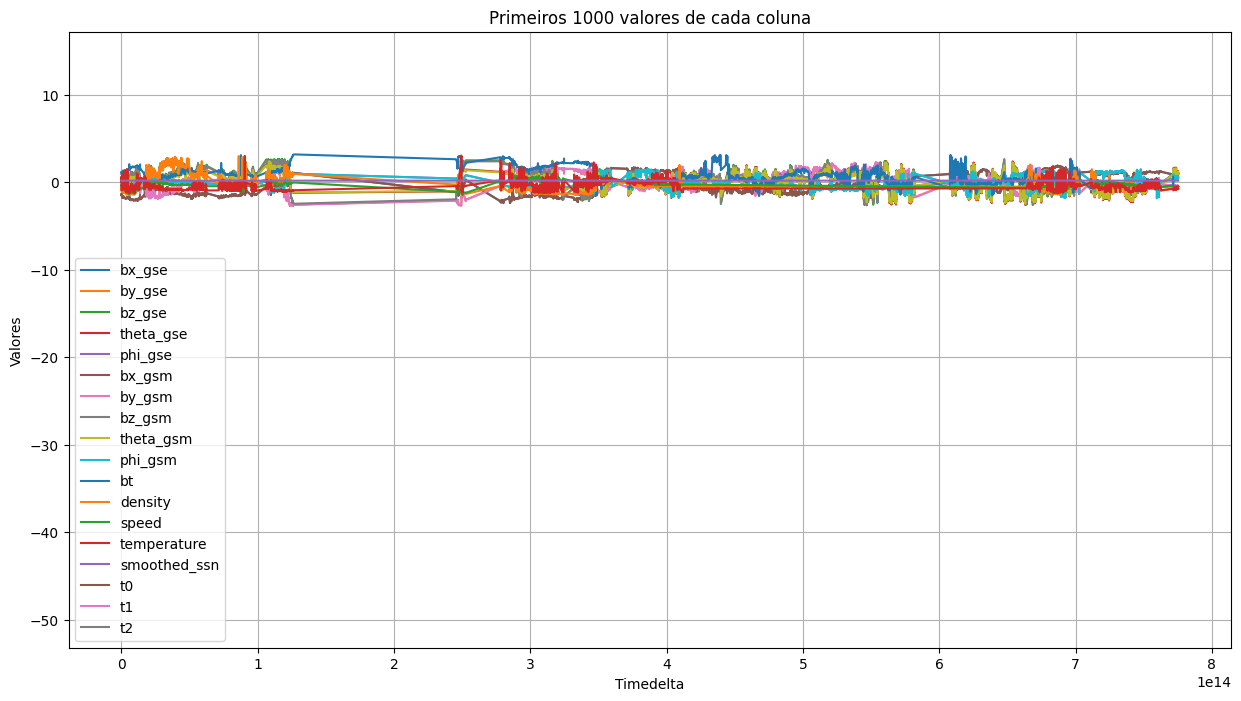

In [30]:
plot_data = df_normalized[df_normalized.index.get_level_values(0) == "train_a"].head(10000)

x_values = plot_data.index.get_level_values(1)

plt.figure(figsize=(15, 8))

for col in plot_data.columns:
    plt.plot(x_values, plot_data[col], label=col)

plt.title('Primeiros 1000 valores de cada coluna')
plt.xlabel('Timedelta')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)

plt.show()

In [31]:
df_normalized['t0'] = df_normalized['t0'].interpolate().ffill().bfill()
df_normalized['t1'] = df_normalized['t1'].interpolate().ffill().bfill()
df_normalized['t2'] = df_normalized['t2'].interpolate().ffill().bfill()

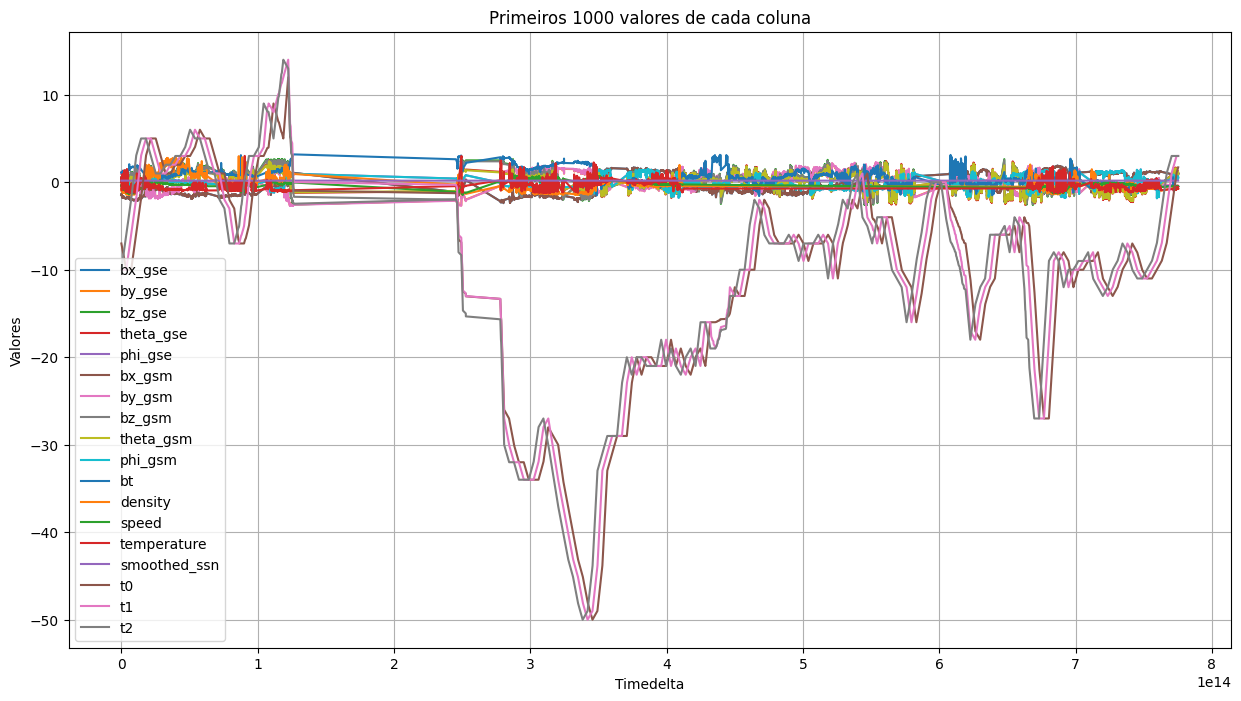

In [32]:
plot_data = df_normalized[df_normalized.index.get_level_values(0) == "train_a"].head(10000)

x_values = plot_data.index.get_level_values(1)

plt.figure(figsize=(15, 8))

for col in plot_data.columns:
    plt.plot(x_values, plot_data[col], label=col)

plt.title('Primeiros 1000 valores de cada coluna')
plt.xlabel('Timedelta')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)

plt.show()

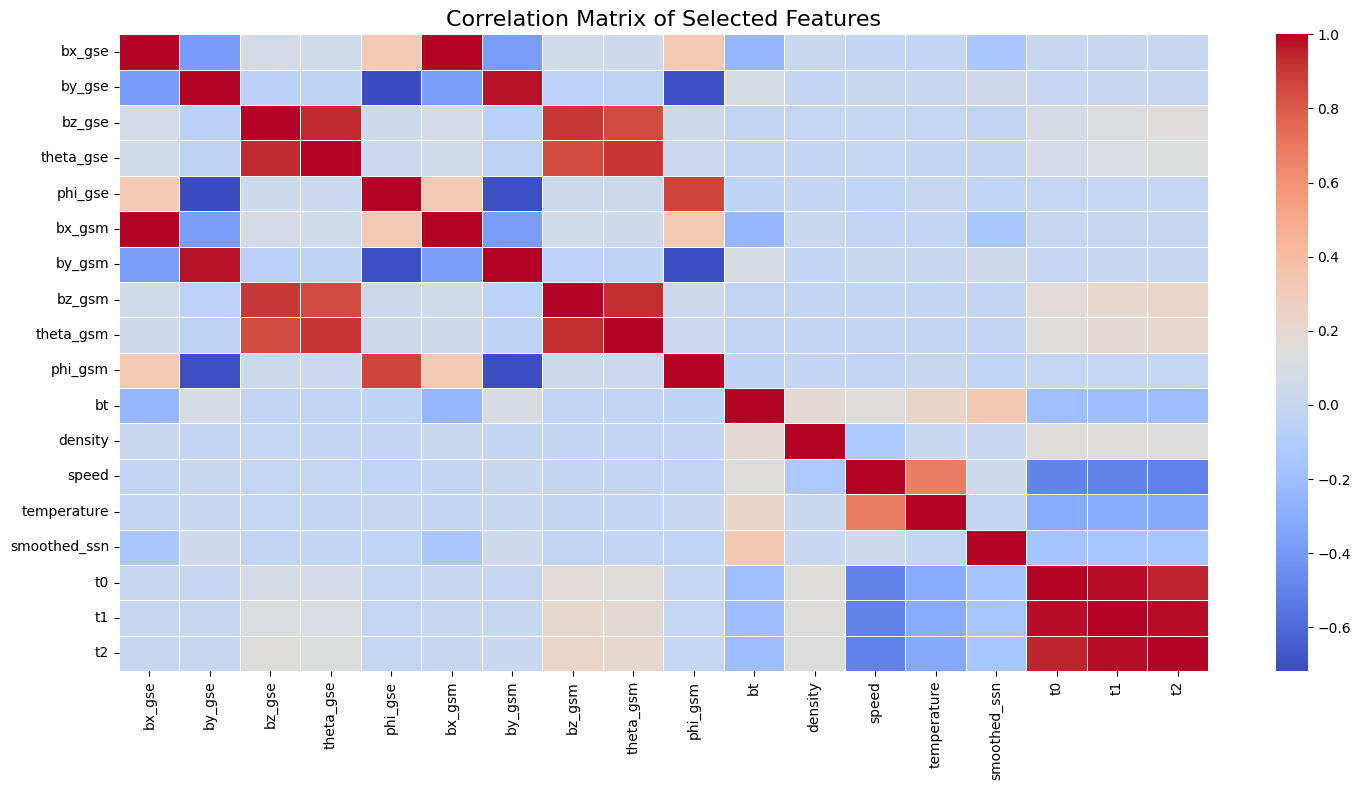

In [33]:
plot_data = df_normalized

corr_matrix  = plot_data.corr()

plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Selected Features', fontsize=16)
plt.tight_layout()
plt.show()

In [34]:
assert (df_normalized.isna().sum() == 0).all()

In [35]:
import gc
gc.collect()

8353

In [36]:
del final_data
del sw_data
del ssn_data
del labels_data

In [37]:
df = df_normalized.copy()

# Model train

In [38]:
def split_data(df: pd.DataFrame, include_val: bool = True, include_test: bool = True):
    """
    Splits the data into training, validation, and test sets based on a 75% train,
    20% validation, and 5% test split. Optionally, validation and test sets can
    be excluded by passing False to 'include_val' or 'include_test'.

    Parameters:
    df (pd.DataFrame): DataFrame containing the features and target variables.
    include_val (bool): Whether to include validation set (default: True).
    include_test (bool): Whether to include test set (default: True).

    Returns:
    tuple: X_train, y_train, X_val, y_val, X_test, y_test. If 'include_val' or
           'include_test' is False, their corresponding sets will be None.
    """
    train_indices = []
    test_indices = []
    val_indices = []

    # Group by period and apply 75% train, 20% validation, 5% test split
    for group_name, group_data in df.groupby(df.index.get_level_values(0)):
        X_group = group_data.drop(columns=['t0', 't1', 't2'])
        y_group = group_data[['t0', 't1', 't2']]

        # First, split into train (75%) and temp (25%)
        X_train_group, X_temp_group, y_train_group, y_temp_group = train_test_split(
            X_group, y_group, test_size=0.25, random_state=42
        )

        if include_val or include_test:
            # Split temp set into 80% validation and 20% test
            X_val_group, X_test_group, y_val_group, y_test_group = train_test_split(
                X_temp_group, y_temp_group, test_size=0.2, random_state=42
            )

        # Collect train indices
        train_indices.append(X_train_group.index)

        if include_val:
            val_indices.append(X_val_group.index)

        if include_test:
            test_indices.append(X_test_group.index)

    # Concatenate indices
    train_indices = pd.Index(np.concatenate(train_indices))
    if include_val:
        val_indices = pd.Index(np.concatenate(val_indices))
    if include_test:
        test_indices = pd.Index(np.concatenate(test_indices))

    # Separate train set
    X_train, y_train = df.loc[train_indices].drop(columns=['t0', 't1', 't2']), df.loc[train_indices][['t0', 't1', 't2']]

    # Separate validation and test sets if required
    if include_val:
        X_val, y_val = df.loc[val_indices].drop(columns=['t0', 't1', 't2']), df.loc[val_indices][['t0', 't1', 't2']]
    else:
        X_val, y_val = None, None

    if include_test:
        X_test, y_test = df.loc[test_indices].drop(columns=['t0', 't1', 't2']), df.loc[test_indices][['t0', 't1', 't2']]
    else:
        X_test, y_test = None, None

    return X_train, y_train, X_val, y_val, X_test, y_test, train_indices, val_indices, test_indices

In [39]:

X_train, y_train, X_val, y_val, X_test, y_test, train_indices, val_indices, test_indices = split_data(df, False)

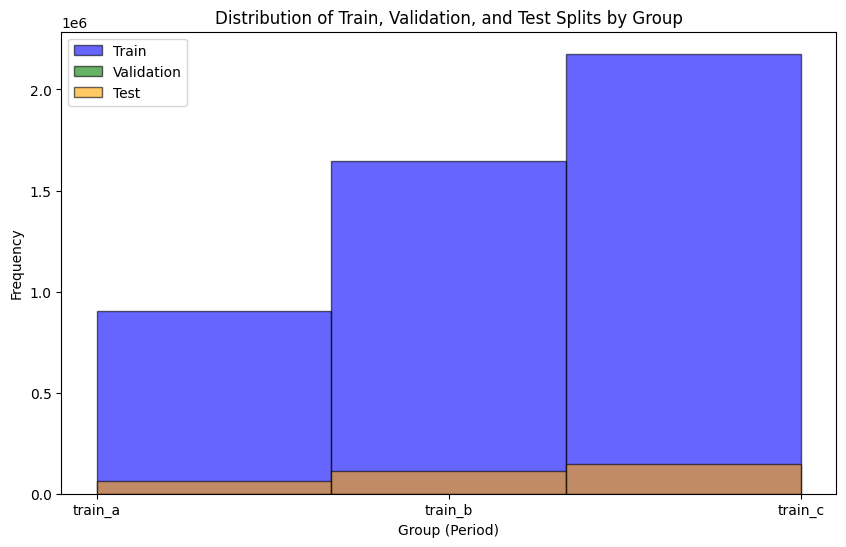

In [40]:

# Obter os valores do índice para o conjunto de treino, validação e teste
train_group_values = df.loc[train_indices].index.get_level_values(0)
val_group_values = df.loc[val_indices].index.get_level_values(0)
test_group_values = df.loc[test_indices].index.get_level_values(0)

# Criar os histogramas
plt.figure(figsize=(10, 6))

plt.hist(train_group_values, bins=len(set(df.index.get_level_values(0))), alpha=0.6, label='Train', color='blue', edgecolor='black')
plt.hist(val_group_values, bins=len(set(df.index.get_level_values(0))), alpha=0.6, label='Validation', color='green', edgecolor='black')
plt.hist(test_group_values, bins=len(set(df.index.get_level_values(0))), alpha=0.6, label='Test', color='orange', edgecolor='black')

# Adicionar rótulos e título
plt.xlabel('Group (Period)')
plt.ylabel('Frequency')
plt.title('Distribution of Train, Validation, and Test Splits by Group')
plt.legend()

# Exibir o gráfico
plt.show()

In [41]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.multioutput import MultiOutputRegressor

# Função para calcular as métricas de avaliação (para múltiplas saídas)
def evaluate_model_multi(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred, multioutput='uniform_average')  # Média das saídas
    rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='uniform_average'))
    mae = mean_absolute_error(y_test, y_pred, multioutput='uniform_average')
    return r2, rmse, mae

results = {}

xgb = MultiOutputRegressor(XGBRegressor(
    random_state=42,
    tree_method='gpu_hist', 
    gpu_id=0 
))
xgb.fit(X_train, y_train)
r2, rmse, mae = evaluate_model_multi(xgb, X_test, y_test)
results['XGBoost'] = {'R²': r2, 'RMSE': rmse, 'MAE': mae}

# CatBoost (com suporte a GPU)
catboost = MultiOutputRegressor(CatBoostRegressor(
    random_state=42,
    verbose=0,
    task_type='GPU',
    devices='0'
))
catboost.fit(X_train, y_train)
r2, rmse, mae = evaluate_model_multi(catboost, X_test, y_test)
results['CatBoost'] = {'R²': r2, 'RMSE': rmse, 'MAE': mae}

/usr/local/lib/python3.9/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/xgboost/core.py:158: UserWarning: [20:12:22] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.9/dist-packages/xgboost/core.py:158: UserWarning: [20:12:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.9/dist-packages/xgboost/core.py:158: UserWarning: [20:12:24] WARNING: /w

In [42]:
results_df = pd.DataFrame(results).T
results_df

,R²,RMSE,MAE
XGBoost,0.675034,7.661105,5.599717
CatBoost,0.649063,7.961570,5.826377


In [43]:
import pickle


with open(f"CatBoost.pkl", "wb") as f:
    pickle.dump(catboost, f)


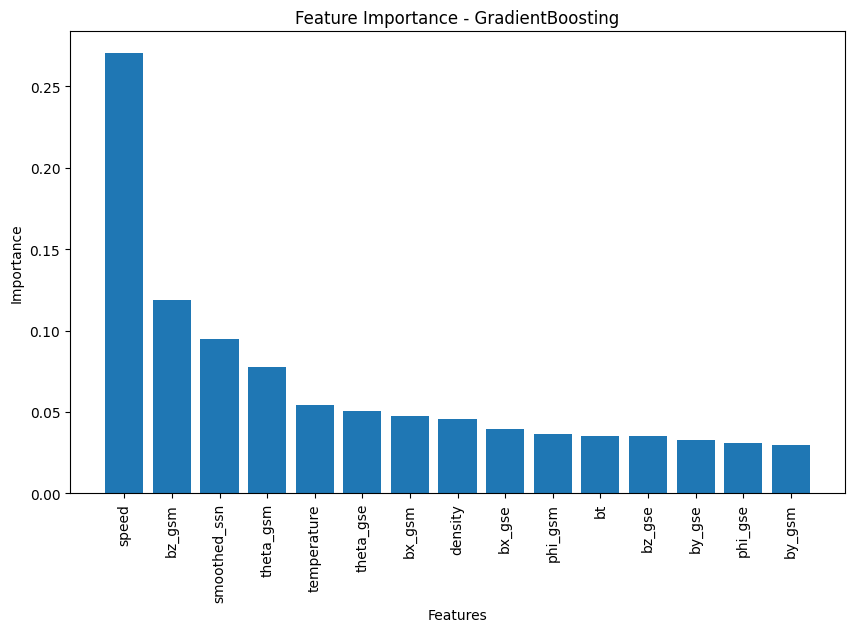

In [44]:
import matplotlib.pyplot as plt
import numpy as np

feature_importances = xgb.estimators_[0].feature_importances_

indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importance - GradientBoosting")
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), np.array(X_train.columns)[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()